 ## $\underline{ \textbf{Data assimilation on a PAPA}}$
 
 
 
 **Statut** : In progress
 
**Purpose**: We propose here an assimilation problem coupled with Solver DL (deep learning), the goal is to infer the mass **m** and the moment of inertia **$I_\alpha$** of a PAPA from observations made on the displacements.
 
 
 **Reference** : 
 
 [1] : [ V. Mons, J.-C. Chassaing, T. Gomez, P. Sagaut, "Reconstruction of unsteady viscous flows using data assimilation schemes", JCP 316 (2016) p. 255-280.](https://dropsu.sorbonne-universite.fr/s/oP8s9CeNS5zW5DG)
 
 [2] : [ A. Chaarane, "Data Assimilation for Flow Induced Vibrations",Stage, InstitutJean Le Rond D’Alembert, 2021.](https://dropsu.sorbonne-universite.fr/s/kr97PiKoJ8jFHfw)
 
 
-----------------------------------
**A. Chaarane**, Institute  D'Alembert, (3 May 2022)

-----------------------------------

In [5]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import copy
# ------ Importation Local
# utils for Post-Trait ( plot, ..)
sys.path.append("../")
from Post_Trait import POSTRAIT

#--- DATA : output of DA code

# DATA : Config 1
DA_prfx   = "Mass_Ialpha_60/"
PATH      = "PAPA_FNN/" + DA_prfx
PATH_DATA = "../../DATA/DA_4DEnVar_V1/"+PATH
PATH_CONF = "../../Inference_Problem/PAPA/" 
sys.path.append(PATH_CONF)



PST = POSTRAIT(PATH_DATA)
PST.label ="DA(1)/ML"



# DATA : Config 2
PATH2      = "PAPA/" + DA_prfx
PATH_DATA2 = "../../DATA/DA_4DEnVar_V1/"+PATH2
PST2 = POSTRAIT(PATH_DATA2)
PST2.label = "DA(1)"


In [41]:
PST.show_cfg()

-------------------------------------------------------------------------------------------------------------------
                                                Parametres                                         
--------------------------------------------------------------------------------------------------------------------
     Modele name      :                   PAPA                
     DA Method        :                   4DEnVar (V1)        
     Uncertains param :                                                       
                  name     : mass   I_alpha
                 reference : mass = 87.07   I_alpha = 3.73   
                 estimate  : mass = 75.0   I_alpha = 1.8   
                                                                         
     Nbr Iteration =  60  |  Nbr Ensemble =   30  | Param_sigma = 0.300000
                                                                         
     Observations     :                                                  

### Function Cost


$\newcommand{\Gama}{\boldsymbol{\gamma}} 
\newcommand{\B}{\boldsymbol{B}} 
\newcommand{\C}{\boldsymbol{C}} 
\newcommand{\Gamae}{\boldsymbol{\gamma}^{(e)}}
\newcommand{\YN}{( \boldsymbol{y}{_k})_{0\leq k\leq N}}
\newcommand{\XN}{( \boldsymbol{x}{_k})_{0\leq k\leq N}}
\newcommand{\Ep}{ \boldsymbol{E}'}
\newcommand{\Beta}{ \boldsymbol{\beta}}
\newcommand{\h}{ \boldsymbol{h}}
\newcommand{\x}{ \boldsymbol{x}}
\newcommand{\y}{ \boldsymbol{y}}$

The DA framework addressed in this study is to infer the control vector $\Gama$ assuming that observations $\boldsymbol{y}$  are given by
$\boldsymbol{y}=\boldsymbol{h}(\boldsymbol{x}) +\boldsymbol{\epsilon}^0 $, with $\h$  the observation operator and $\boldsymbol{\epsilon}^0$  the measurement error.
If the model is supposed to be exact,  the control vector is sought as a solution which minimises the following cost function

\begin{align}
J(\Gama) &= \; \frac{1}{2} \Vert \h\big(\x (\Gama)\big) - \y \Vert^2_{\C^{-1}} 
%\textbf{Grad}_{obs} &=\sum_{n=0}^{N} \boldsymbol{H}_k '^T \C^{-1}\boldsymbol{d}\\
%\textbf{Hess}_{obs}&=\sum_{n=0}^{N} \boldsymbol{H}_k '^T \C^{-1}\boldsymbol{H}_k '
\end{align}

where $\C$ denotes the covariance matrix of the measurement error and $ \Vert \cdot \Vert ^2_{\C^{-1}} = \cdot ^T \C ^{-1} \cdot$.

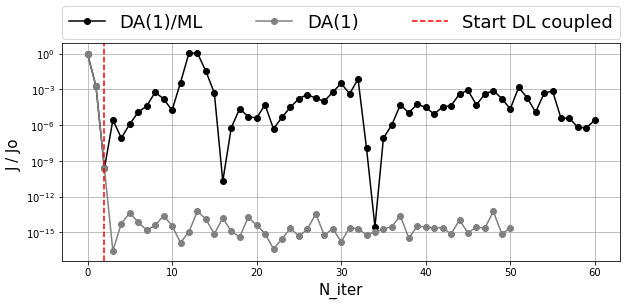

In [42]:
plt.figure(figsize=(10,4))
PST.plot_Jcost(label = PST.label)
PST2.plot_Jcost(c="grey",label = PST2.label)
plt.axvline(x=2,label="Start DL coupled",c="r",linestyle='--')
plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                            mode="expand", borderaxespad=0, ncol=4,fontsize=18)
plt.show()

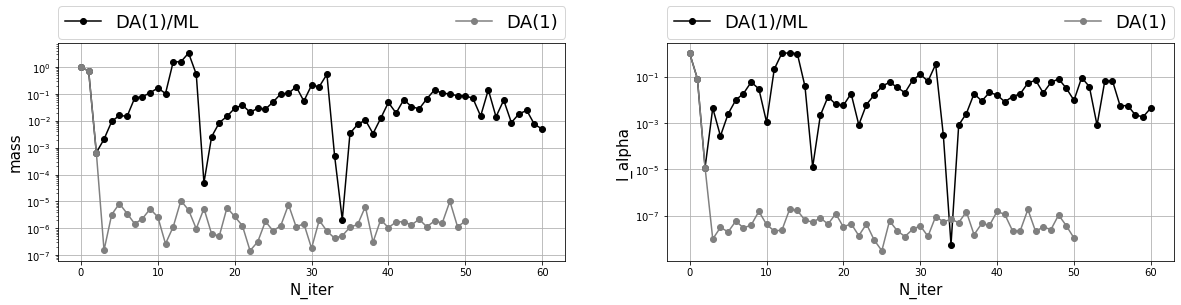

In [43]:
n_col = 2
plt.figure(figsize=(20,4))

N_iter  = [j for j in range(len(PST.Param_error))]
N_iter2 = [k for k in range(len(PST2.Param_error))]
k=1
for i,name in enumerate(PST.CFG.Param_Name) :
    
    plt.subplot(1,n_col,k)
    plt.plot(N_iter, PST.Param_error[:,i]/PST.Param_error[0,i],'-o', c="k",label = PST.label)
    plt.plot(N_iter2, PST2.Param_error[:,i]/PST2.Param_error[0,i],'-o', c="grey",label = PST2.label)
    plt.xlabel('N_iter',fontsize=15)
    plt.ylabel(name,fontsize=15)
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                            mode="expand", borderaxespad=0, ncol=4,fontsize=18)    
    plt.grid()
    if k ==n_col and i!=len(PST.CFG.Param_Name)-1:
        plt.show()
        plt.figure(figsize=(20,4))
        k=1
    else :
        k+=1


In [44]:
# plt.figure(figsize=(10,4))
# PST.plot_Param_error(label = PST.label)
# PST2.plot_Param_error(c="grey",label = PST2.label)
# plt.axvline(x=2,label="Start DL coupled",c="r",linestyle='--')
# plt.grid(True)
# plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
#                             mode="expand", borderaxespad=0, ncol=4,fontsize=18)
# plt.show()

Here we plot the cost function $J$ as a function of the number of iterations, we plot the logarithm of ($J/J_0$) where $J_0$ is the cost caculated with the initialization vector.  We can see that the coupling with Solver DL has an impact on the convergence of the cost function, as the predictions are not perfect. 

### Control Vectors  

In [45]:
PST.show_param_ref_opti_est(True)

+----------------+---------+-----------+
|                |    mass |   I_alpha |
+================+=========+===========+
| Reference      | 87.07   |   3.73    |
+----------------+---------+-----------+
| Initialisation | 75      |   1.8     |
+----------------+---------+-----------+
| Optimized      | 87.1298 |   3.73862 |
+----------------+---------+-----------+


The optimized vector presented here is the control vector obtained with the DA optimization in the last iteration, we see that it is equal to the reference with an accuracy of about $10^{-2}$. This shows that despite the convergence error due to the coupling with the DL solver, the optimization process remains satisfactory.

### Reconstruction of airfoil oscillations. 

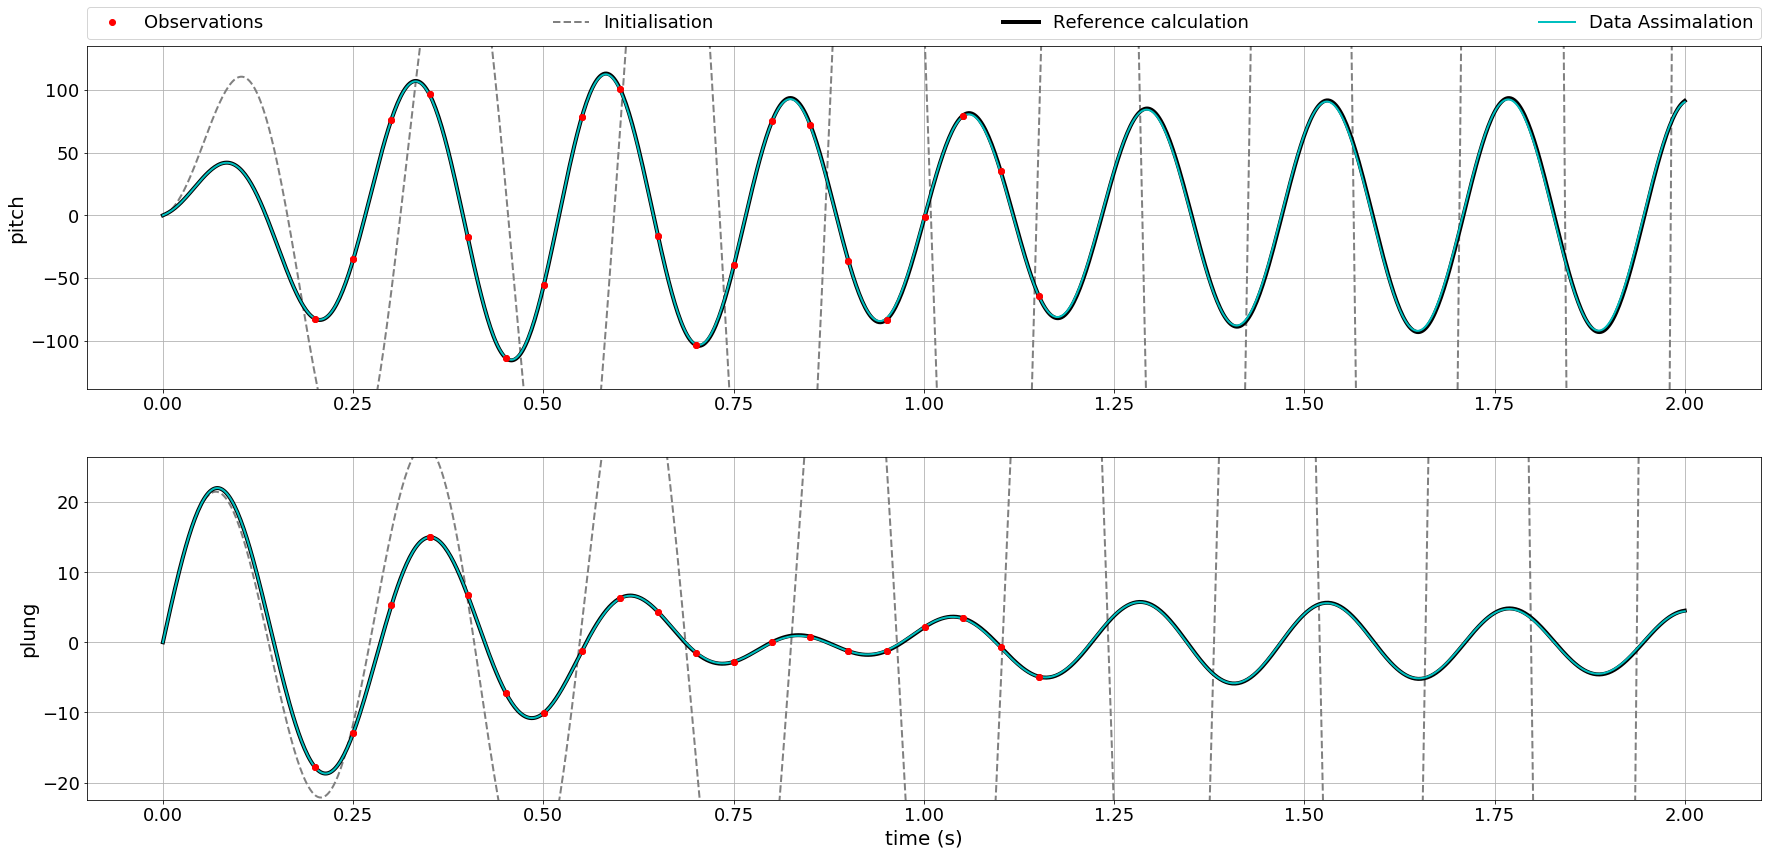

In [46]:
plt.figure(figsize=(30,150))
PST.plot_obs_ref_est_opt()

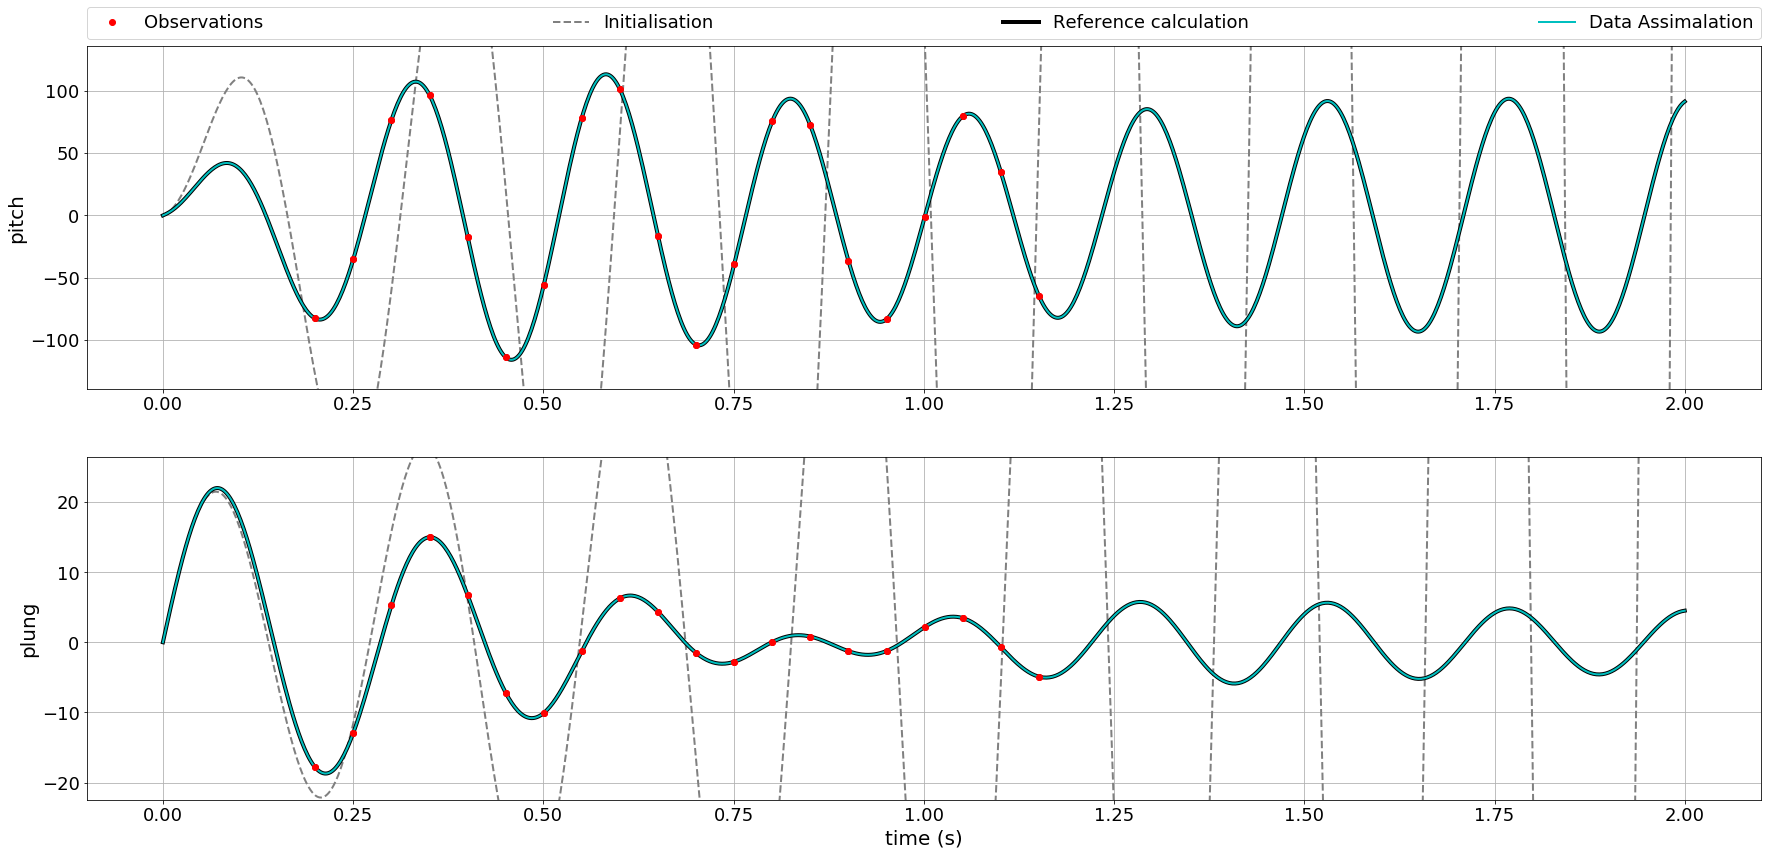

In [47]:
plt.figure(figsize=(30,150))
PST2.plot_obs_ref_est_opt()

We have represented the reconstruction of the airfoil displacements as a function of time. We have in red the observations, in grey the initial calculation which is very far from the reference solution which is in cyan color. We can see that after the optimization process we manage to reconstruct perfectly the displacements of the profile by passing over the observations and which are almost equal to the reference state at long times. 

### Sample analysis during the optimisation process. 

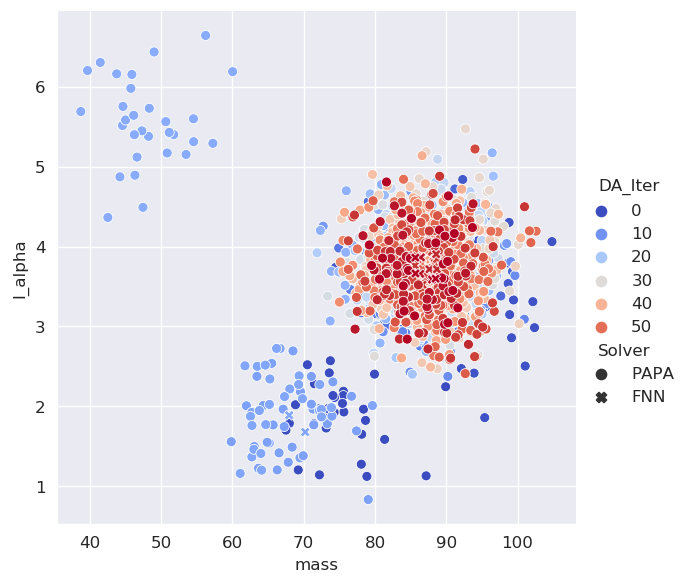

In [48]:
df_samples = copy.copy(PST.get_samples_df())
df_samples["Data"] = ""

with sns.axes_style("darkgrid"):
    ax=sns.relplot(data=df_samples, x=PST.CFG.Param_Name[0], y=PST.CFG.Param_Name[1],hue ="DA_Iter",palette="coolwarm",style="Solver")
    ax.fig.set_dpi(120)

We display above a part of the samples, we have a total of $N_{ens} \times N_{iter}$ =$40\times3$  samples. For a better analysis, we can visualize them on the figure above.  

In [49]:
#sns_plot =sns.pairplot(df_samples, vars = PST.CFG.Param_Name, hue ="DA_Iter", palette="coolwarm")#,markers=markers)


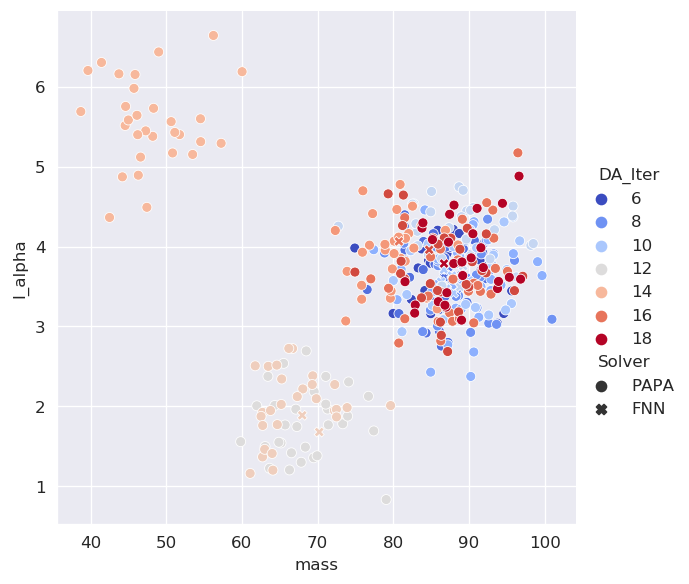

In [54]:
I_clust = 6
df_samples_clust =df_samples.loc[ (df_samples["DA_Iter"] >=I_clust) & (df_samples["DA_Iter"] <=18)  ]

with sns.axes_style("darkgrid"):
    ax=sns.relplot(data=df_samples_clust, x=PST.CFG.Param_Name[0], y=PST.CFG.Param_Name[1],hue ="DA_Iter",palette="coolwarm",style="Solver")
    ax.fig.set_dpi(120)
#sns_plot.fig.set_size_inches(40,100)
#plt.grid()
#plt.show()

/tmp/ipykernel_3993534/2514211395.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_samples_Iter["Data"][i] = "Train"


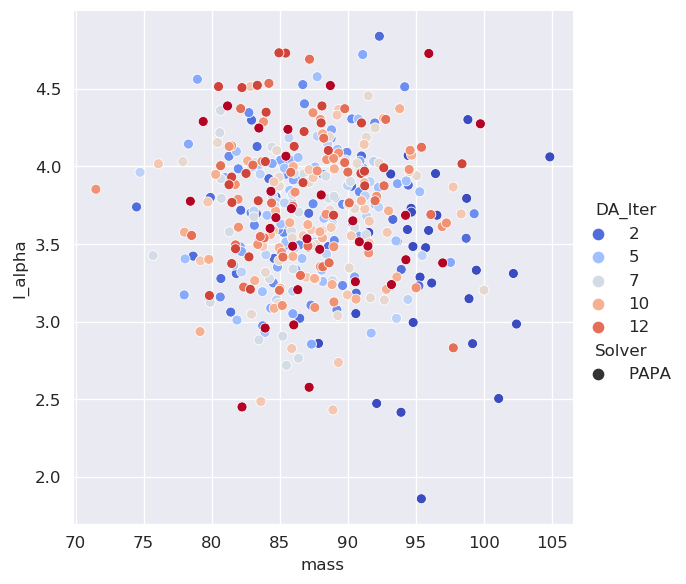

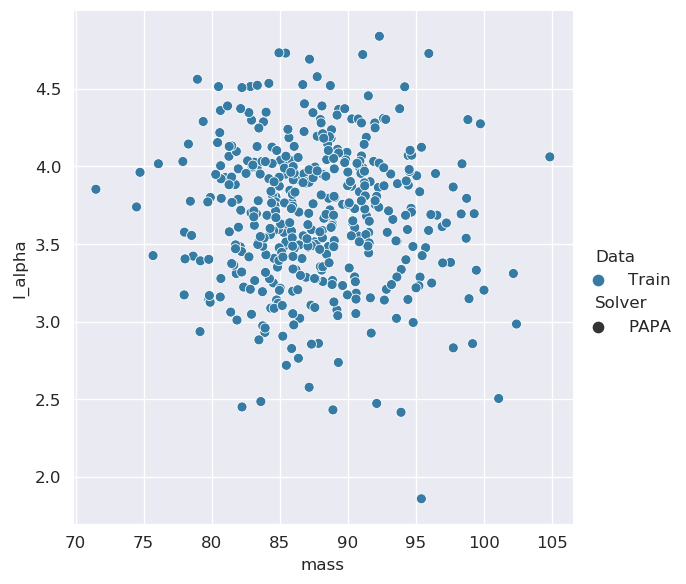

In [38]:
DA_Iter = 14
df_samples_Iter =df_samples_clust.loc[ (df_samples_clust["DA_Iter"] <=DA_Iter) ]
for i in df_samples_Iter.index:
    if df_samples_Iter["DA_Iter"][i] ==DA_Iter  and df_samples_Iter["Solver"][i] ==PST.CFG.DL_Model:
        df_samples_Iter["Data"][i] = "Pred"
    else :
        df_samples_Iter["Data"][i] = "Train"
        
        
with sns.axes_style("darkgrid"):
    ax=sns.relplot(data=df_samples_Iter, x=PST.CFG.Param_Name[0], y=PST.CFG.Param_Name[1],hue ="DA_Iter",palette="coolwarm",style="Solver")
    ax.fig.set_dpi(120)

#sns_plot.fig.set_size_inches(40,100)
#plt.grid()
#plt.show()

with sns.axes_style("darkgrid"):
    ax=sns.relplot(data=df_samples_Iter, x=PST.CFG.Param_Name[0], y=PST.CFG.Param_Name[1],hue ="Data",palette="mako",style="Solver")
    ax.fig.set_dpi(120)


We represent here the samples obtained at each iteration, we can see that from one iteration to another the samples are grouped to form a kind of cluster. The round samples were propagated with the HF solver and the crossed samples were propagated with the DL solver.

### Comparison of pure DA and DA coupled with LD

### 1] Cost fucntcion 

In [39]:
# load Pure DA 
PATH2      = "PAPA/Mass_Ialpha/"
PATH_DATA2 = "../../DATA/DA_4DEnVar_V1/"+PATH2
PST2 = POSTRAIT(PATH_DATA2)

In [ ]:
# load Pure DA/ML2 
PATH3      = "PAPA_FNN/Mass_Ialpha_tst_FNN2/"
PATH_DATA3 = "../../DATA/DA_4DEnVar_V1/"+PATH3
PST3 = POSTRAIT(PATH_DATA3)

In [ ]:
plt.figure(figsize=(20,6))
PST.plot_Jcost(label="DA/ML")
PST2.plot_Jcost(label="DA",c="grey")
PST3.plot_Jcost(label="DA/ML_2",c="m")
plt.axvline(x=5,label="Start ML couplage",c="r",linestyle='--')

plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                            mode="expand", borderaxespad=0, ncol=4,fontsize=18)

plt.show()

We can see that pure DA has a lower level of convergence than DA/DL, which is normal due to the prediction error of the DL solver.

### 2] optimal control parameters  



In [ ]:

all_param_opti   = np.vstack([PST.all_param_opti,PST2.all_param_opti,PST3.all_param_opti])
optimiseur       = len(PST.all_param_opti)*["DA/DL"] + len(PST2.all_param_opti)*["DA"]

DA_iter = np.arange(len(PST.all_param_opti))
DA_iter = np.vstack([DA_iter,DA_iter,DA_iter])
DA_iter = DA_iter.reshape(-1)


dict_param_opti  = {}

dict_param_opti["Optimizer"] = optimiseur
for dim in range(PST.CFG.Param_Dim) :
    dict_param_opti[PST.CFG.Param_Name[dim]] = all_param_opti[:,dim]
dict_param_opti["DA_Iter"]   =DA_iter

df_param_opti = pd.DataFrame.from_dict(dict_param_opti)
df_param_opti.head(3)

In [ ]:
with sns.axes_style("darkgrid"):
    ax=sns.relplot(data=df_param_opti, x=PST.CFG.Param_Name[0], y=PST.CFG.Param_Name[1],hue ="DA_Iter",palette="mako",style="Optimizer")
    ax.fig.set_dpi(120)

We present here the optimal control vector obtained at each iteration, to visualize it well we can represent them in the figure below. 

In [ ]:
i =0
n = 5
while i < len(PST.all_param_opti) : 
    
    df_param_opti_zoom = df_param_opti.loc[ (df_param_opti["DA_Iter"] >=i) &  (df_param_opti["DA_Iter"] <i+n)]
    with sns.axes_style("darkgrid"):
        ax = sns.FacetGrid(df_param_opti_zoom, col="DA_Iter", hue="Optimizer")
        ax.map_dataframe(sns.scatterplot, x=PST.CFG.Param_Name[0], y=PST.CFG.Param_Name[1])
        ax.add_legend()
        ax.fig.set_dpi(100)
        ax.set(ylim=(3.05, 3.8))
        ax.set(xlim=(30, 120))
        plt.show()
        
    i+=n
    print("")
    

### 3] Relative Error  

we define the following relative error:

$$ e_r = \frac{\gamma_{opti} - \gamma_{ref} } {\gamma_{ref}} \times 100$$

In [64]:
Er_DA_DL =100* np.abs(PST.all_param_opti - PST.CFG.Param_Ref) /  PST.CFG.Param_Ref 
Er_DA    =100* np.abs(PST2.all_param_opti - PST.CFG.Param_Ref) /  PST.CFG.Param_Ref 



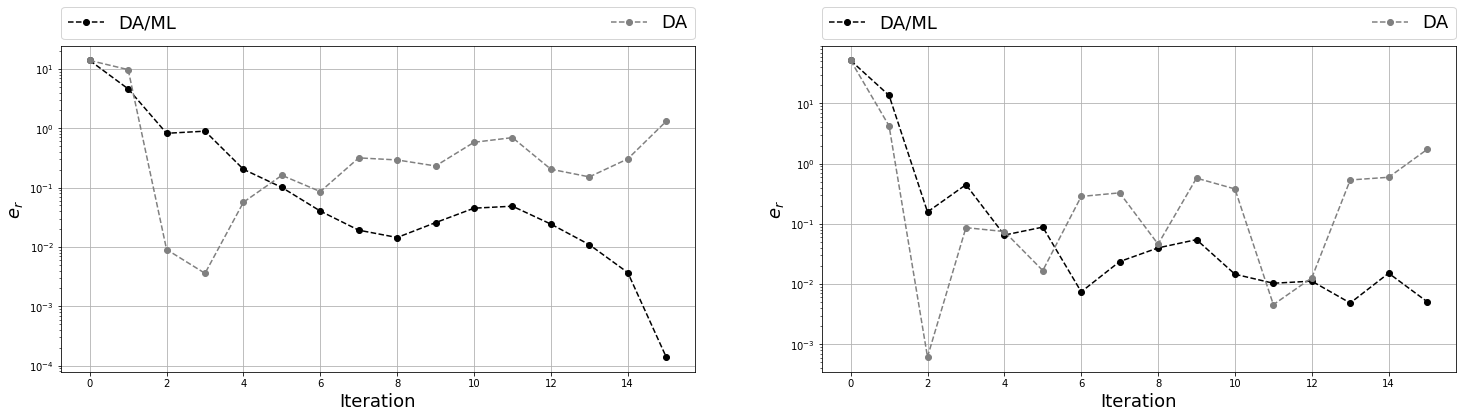

In [66]:
N_iter = np.arange(0,16)
plt.figure(figsize=(25,6))
plt.subplot(1,2,1)
plt.plot(N_iter, Er_DA_DL[0:,0],'--o', c='k',label = "DA/ML")
plt.plot(N_iter,Er_DA[0:,0],'--o', c='grey',label = "DA")
plt.xlabel("Iteration",fontsize=18)
plt.ylabel("$e_r$",fontsize=18)
plt.yscale('log')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                            mode="expand", borderaxespad=0, ncol=4,fontsize=18)
# plt.title( "Error relative to the mass at each iteration" ,fontsize=18 )
plt.grid()

plt.subplot(1,2,2)
plt.plot(N_iter, Er_DA_DL[0:,1],'--o', c='k',label = "DA/ML")
plt.plot(N_iter,Er_DA[0:,1],'--o', c='grey',label = "DA")
plt.xlabel("Iteration",fontsize=18)
plt.ylabel("$e_r$",fontsize=18)
plt.yscale('log')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                            mode="expand", borderaxespad=0, ncol=4,fontsize=18)
# plt.title( r"Error relative to the $I_{\alpha}$ at each iteration" ,fontsize=18 )
plt.grid()
plt.show()

ValueError: x and y must be the same size

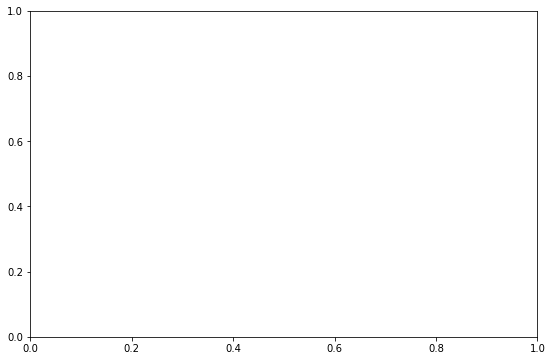

In [58]:
N_iter = np.arange(0,15)
plt.figure(figsize=(20,6))

for i,prm_name in enumerate(PST.CFG.Param_Name) :
    plt.subplot(1,2,i+1)
    plt.scatter(N_iter, PST.all_param_opti[:,i], s=100,marker='o', c='k',label = "DA/ML")
    plt.scatter(N_iter, PST2.all_param_opti[:,i],s=100,marker='o', c='grey',label = "DA")
    plt.scatter(N_iter, PST3.all_param_opti[:,i],s=100,marker='o', c='m',label = "DA/ML_2")
    
    # plt.errorbar(N_iter, PST.all_param_opti[:,i], yerr = Er_DA[:,i], c='k')
    
    plt.axhline(y=PST.CFG.Param_Ref[i],c="b",linestyle='--',lw=0.5,  label="Ref")
    plt.xlabel("Iteration",fontsize=18)
    plt.ylabel(prm_name,fontsize=18)
    plt.ylim(PST.CFG.Param_Ref[i]-0.01*PST.CFG.Param_Ref[i], PST.CFG.Param_Ref[i]+0.01*PST.CFG.Param_Ref[i])
    plt.grid()
    plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                            mode="expand", borderaxespad=0, ncol=4,fontsize=18)



In [ ]:
a = np.array([[1,2],[0,5],[-5,5]])
b = np.array([5,2])
a/b

In [ ]:
1/5